In [112]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta, date, time
import matplotlib.pyplot as plt
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', 150, 'display.max_rows', 100, 'display.max_colwidth', 15)
%matplotlib inline
# get directory address
path= os.getcwd()+"/"

# Flights EDA
> load data

In [113]:
col_names= ["cancelled", "month", "dep_time", "uniq_carrier", "sched_elap_time", "arr_delay", "dep_delay", "dis_ml"]
#col_names= ["cancelled", "month", "departuretime", "uniquecarrier", "schedelapsedtime", "arrdelay", "depdelay", "distance"]
col_names

['cancelled',
 'month',
 'dep_time',
 'uniq_carrier',
 'sched_elap_time',
 'arr_delay',
 'dep_delay',
 'dis_ml']

In [114]:
df= pd.read_csv(path+"CancelledFlights.csv", header= None, names= col_names)
df

,cancelled,month,dep_time,uniq_carrier,sched_elap_time,arr_delay,dep_delay,dis_ml
0,1,12,3214,UA,134,0,0,679.0
1,1,12,830,DL,90,0,0,214.0
2,1,1,1835,UA,213,0,0,1605.0
3,1,4,1730,AA,80,0,0,235.0
4,1,7,1442,UA,103,0,0,413.0
...,...,...,...,...,...,...,...,...
5995,0,6,1725,AA,115,17,30,597.0
5996,0,9,1945,DL,127,-19,-9,752.0
5997,0,8,1850,DL,101,6,-4,481.0
5998,0,7,1720,AA,210,178,42,1302.0


### 1.1 Data Types and Descriptive Stats

> check data types
* all columns except uqiquecarrie and distance are integer
* we will have to change the cancelled column to categorical as its showing 1,0 boolean values which present if the flight is cancelled or not
* departure time is in integer format that needs changing to date format
* may be unique carrier also needs to be changed to categorical

In [115]:
pd.DataFrame(df.dtypes).T

,cancelled,month,dep_time,uniq_carrier,sched_elap_time,arr_delay,dep_delay,dis_ml
0,int64,int64,int64,object,int64,int64,int64,float64


> table below shows the summary of the data.
* Max departure time is 3313 which needs further investigation as it cannot be more than 2359 (i am assuming its a typo, from 23 to 33)
* Most frequent carrier is AA.
* Average flight duration is 161 mins
* average arrival delay is 8 mins with a max delay of 410 mins 
* average departure delay is 9 mins with a max delay of 387 mins
* Average distance travelled by flights is 986.2 km
* all variable show count of 6000 except for dis_ml which is 5971, which means this column has missing values.

In [116]:
df.describe(include="all").round(1)

,cancelled,month,dep_time,uniq_carrier,sched_elap_time,arr_delay,dep_delay,dis_ml
count,6000.0,6000.0,6000.0,6000,6000.0,6000.0,6000.0,5971.0
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,2476,NaN,NaN,NaN,NaN
mean,0.2,6.2,1332.1,NaN,161.7,8.1,9.1,986.3
std,0.4,3.4,461.3,NaN,78.1,35.8,31.7,646.3
min,0.0,1.0,5.0,NaN,40.0,-72.0,-16.0,68.0
25%,0.0,3.0,934.8,NaN,105.0,-8.0,-3.0,547.0
50%,0.0,6.0,1325.0,NaN,145.0,0.0,0.0,837.0
75%,0.0,9.0,1715.0,NaN,200.0,10.0,6.0,1249.0


* convert the dep_time column to string and then replace 3 with 2 as military time cannot go more than 2359.
* convert integers to 4 digits format so i can convert it into time format

In [117]:
# max time can have 24 hours. if a time string starts with 3 i.e. 30000 it means it is incorrect and it should be 20000.
df["dep_time"]=  df.dep_time.astype("str").str.replace(r'^3', "2") 
df["time"]= ["0"+ x if len(x)==3 else "00"+ x if len(x)==2 else "0"+x if len(x)==1 else x for x in df.dep_time ]
df["time"]= [datetime.strptime(x,"%H%M").strftime("%H:%M") for x in df.time]
df["hour"] = pd.to_datetime(df.time).dt.hour
df.head()

/var/folders/3d/z1qzqy6s4p5_06dtsnr__3qh0000gn/T/ipykernel_5449/4149556831.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



,cancelled,month,dep_time,uniq_carrier,sched_elap_time,arr_delay,dep_delay,dis_ml,time,hour
0,1,12,2214,UA,134,0,0,679.0,22:14,22
1,1,12,830,DL,90,0,0,214.0,08:30,8
2,1,1,1835,UA,213,0,0,1605.0,18:35,18
3,1,4,1730,AA,80,0,0,235.0,17:30,17
4,1,7,1442,UA,103,0,0,413.0,14:42,14


In [118]:
df.dtypes

cancelled            int64
month                int64
dep_time            object
uniq_carrier        object
sched_elap_time      int64
arr_delay            int64
dep_delay            int64
dis_ml             float64
time                object
hour                 int64
dtype: object

### 1.2 Exploratory Data Visualisations (EDA)

> Histograms shows us some useful information:

* proportion of cancelled vs non cancelled flights is 5000 to 1000.
* Most of the flights have schedule flight duration between 85 to 159. Some flights have travel duration of over 600 mins
* Most of the flights have arrival delay of 0 to 4 mins.
* Most of the flights have departure delay of 0 to 1 mins.
* Some flights have a arrival and departure delay of around 400 mins. I am not sure with my current domain knowledge if it is possible or whether its some sort of reporting error.
* Busiest hours for the flights are between 6am to 6pm.


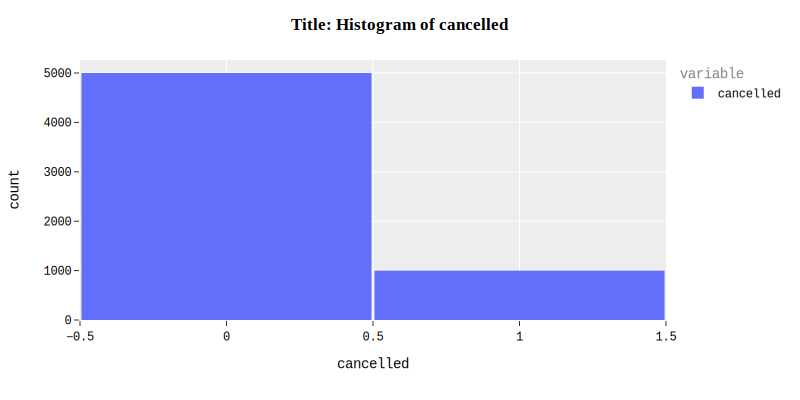

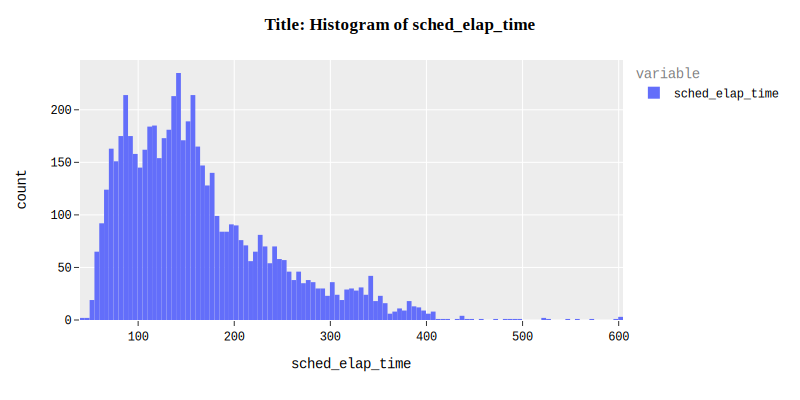

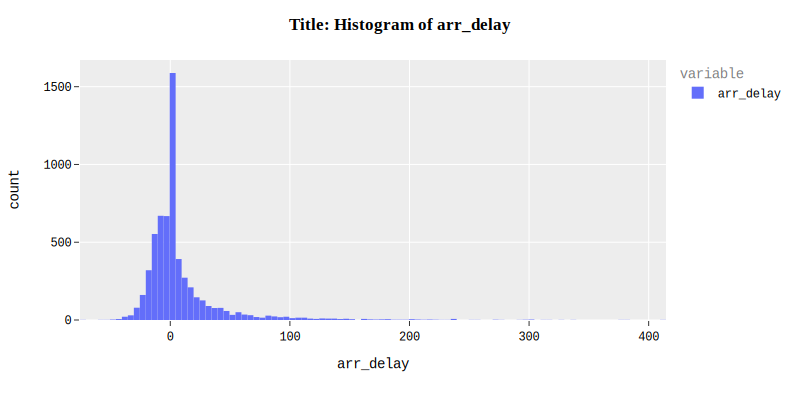

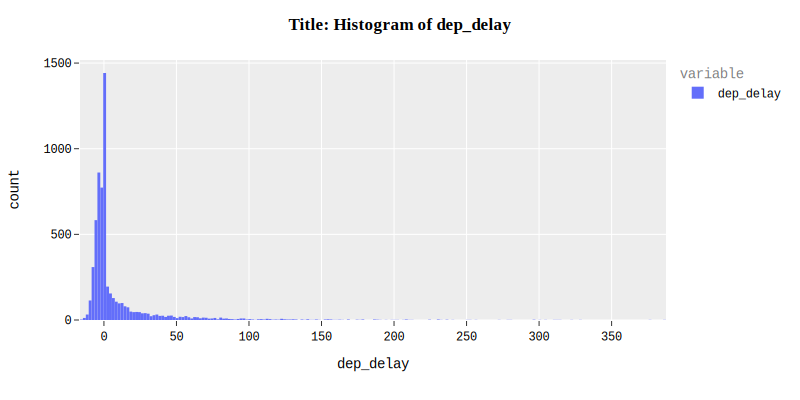

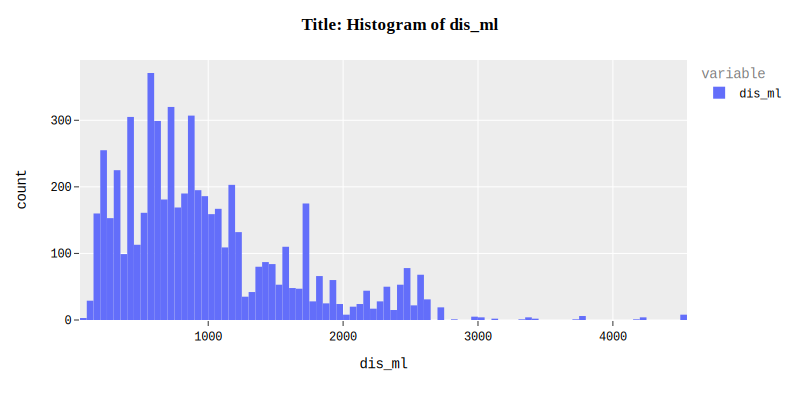

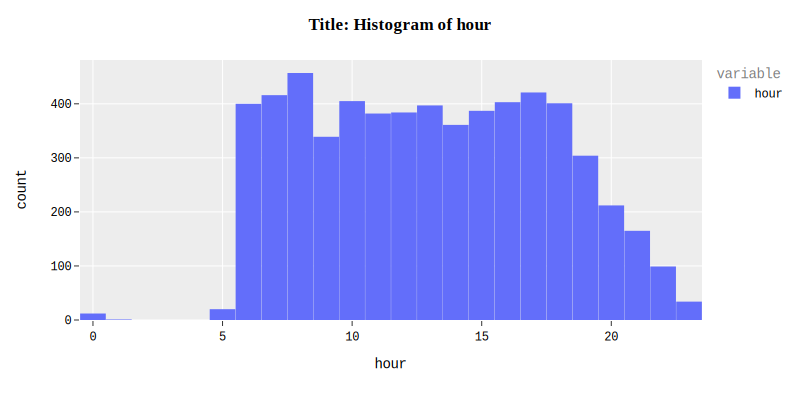

[None, None, None, None, None, None]

In [119]:
#!pip install plotly
import plotly.express as px
#pd.options.plotting.backend = "matplotlib"
pd.options.plotting.backend = "plotly"

def plot_hist(x):
    p=(
        df
        .filter([x])
        .plot.hist(width= 800, height=400)       
        .update_layout(
            template = 'ggplot2',
            bargap=0.01,
            title = "<b> Title: Histogram of {} </b>".format(x),
            xaxis_title = x,                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )        
    )
    return p.show("svg")

list(
    map(
        plot_hist, df.columns[~ df.columns.isin(["uniq_carrier","month", "dep_time", "time"])]
        )
    )

In [120]:
df_mean=(
     df
     .groupby(["cancelled", "uniq_carrier" ])
     .agg(
        mean_elp_time = pd.NamedAgg("sched_elap_time", "mean"),
        mean_arr_del = pd.NamedAgg("arr_delay", "mean"),
        mean_dep_del = pd.NamedAgg("dep_delay", "mean"),
        mean_dis_ml = pd.NamedAgg("dis_ml", "mean"),
        count_cancel = pd.NamedAgg("cancelled", "count")
    )
    .reset_index()
    .assign(uniq_carrier= lambda df_: df_.uniq_carrier.astype("category"),
             cancelled= lambda df_: df_.cancelled.astype("category"),
             perc_flight_cancel= lambda df_: ((df_.count_cancel/df_.count_cancel.sum())).round(4)
             )
)
df_mean

,cancelled,uniq_carrier,mean_elp_time,mean_arr_del,mean_dep_del,mean_dis_ml,count_cancel,perc_flight_cancel
0,0,AA,164.838124,11.558749,11.914271,1034.229798,1983,0.3305
1,0,DL,156.368245,7.652435,7.641094,924.461230,1499,0.2498
2,0,UA,170.829381,9.411067,12.988801,1067.592862,1518,0.2530
3,1,AA,158.154158,0.000000,-0.002028,946.360996,493,0.0822
4,1,DL,125.201058,0.000000,0.264550,632.611702,189,0.0315
5,1,UA,150.751572,0.000000,0.147799,859.153846,318,0.0530


> below Graph shows a comparison of percetage Flights cancelled for each Carrier.
* Highest Number of cancellation are for AA (8.3%) followed by UA (5.3%)

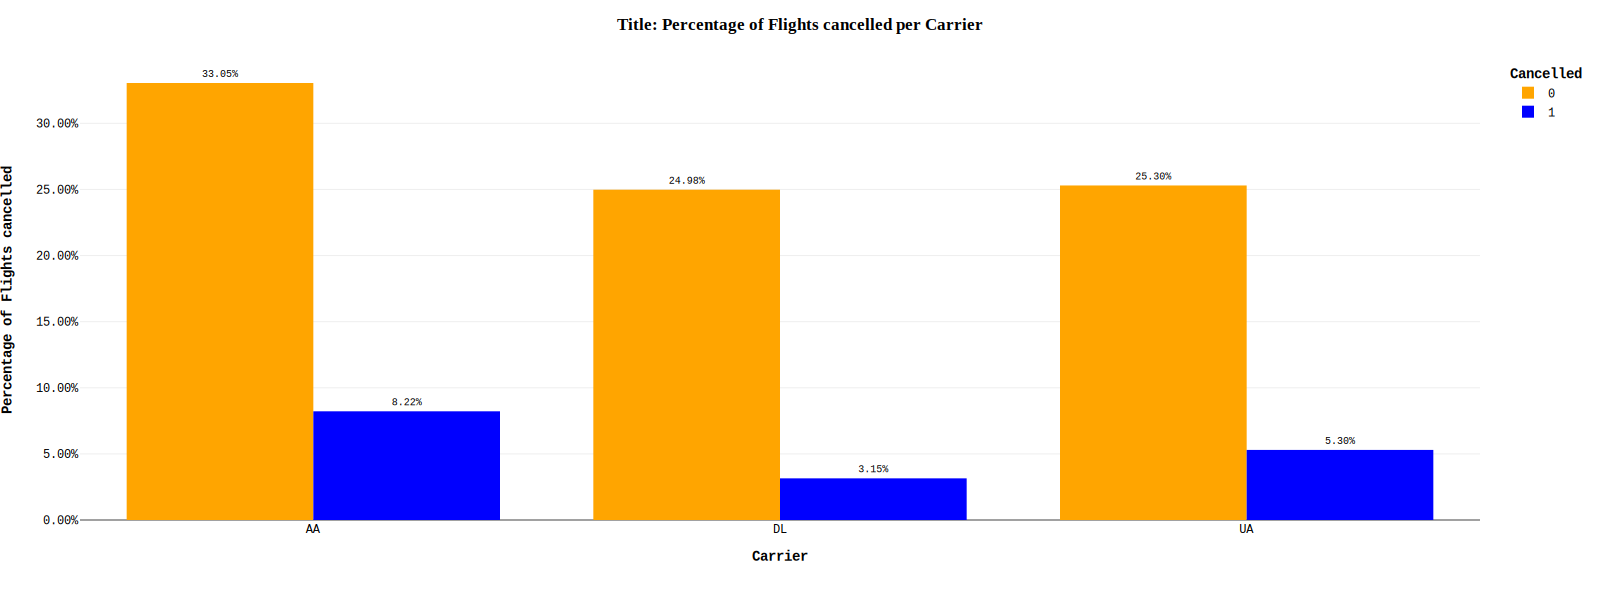

In [121]:
(
    df_mean
    .plot.bar(x="uniq_carrier", y = "perc_flight_cancel",     
              barmode='group', 
              color= "cancelled",
              width= 1600, height=600,
              color_discrete_map={0: 'orange',1: 'blue'},
              labels = "count_cancel", text_auto = True ) 
     .update_traces(textposition='outside', textfont_size =10, 
     #marker_color = ["green", "red", "orange"]
     )       
     .update_yaxes(tickformat= ".2%") 
     .update_layout(                
             template = 'presentation',         
             title = "<b> Title: Percentage of Flights cancelled per Carrier </b>",
             xaxis_title = "<b>Carrier<b>",
             yaxis_title= "<b>Percentage of Flights cancelled<b>",
             font_family="Courier New",
             font_color="black",
             font_size = 12,
             title_font_family="Times New Roman",
             title_font_color="black",        
             legend_title_font_color= "grey",
             legend_title= "<b>Cancelled<b>"
             )        
    ).show("svg")


> below Graph shows a comparison of duration and distance of flight for each Carrier. 
* Average flight duration and distance for cancelled flight is smaller then average flight duration of not cancelled flights. Suggesting the flights with smaller duration often get cancelled.

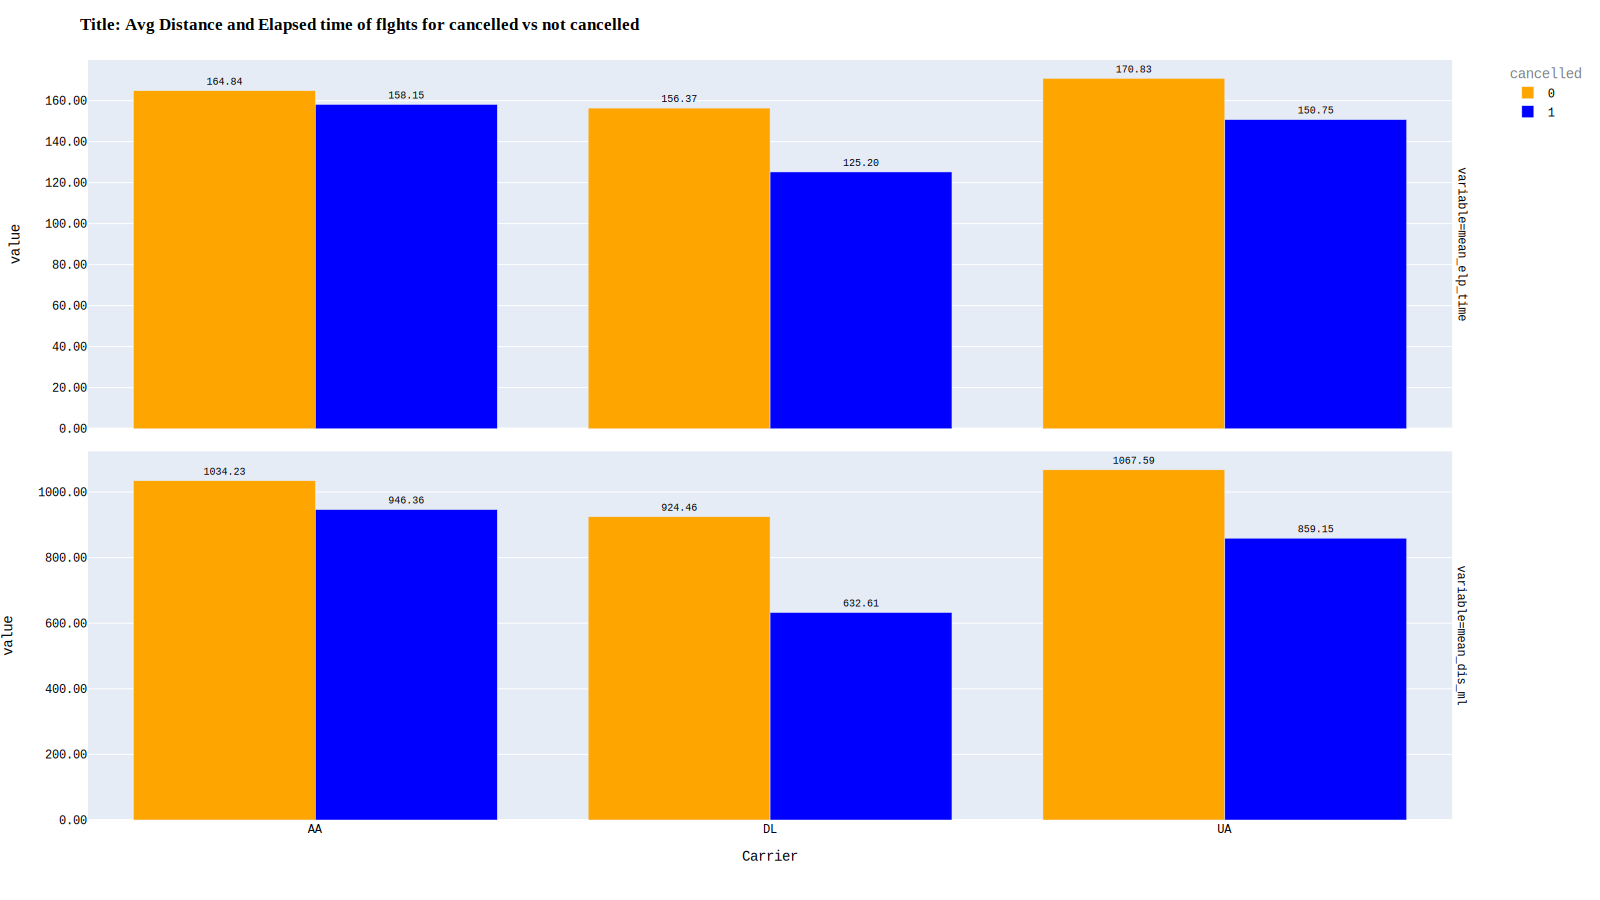

In [122]:
#!pip install regex
import regex as re
p1= (
    df_mean
    .melt(id_vars= ["cancelled", "uniq_carrier"] )
    .query('variable in ["mean_elp_time", "mean_dis_ml"]')
    .plot.bar(x="uniq_carrier", y = "value",     
                barmode='group', 
                color= "cancelled", 
                color_discrete_map={0: 'orange',1: 'blue'},
                facet_row= "variable", 
                text_auto = True,
                width= 1600, height=900, 
                ) 
      .update_traces(textposition='outside', textfont_size =10) 
      .update_yaxes(matches=None,showticklabels=True, tickformat= ".2f" )
      .update_xaxes(matches=None)    
      .update_layout(            
            title = "<b> Title: Avg Distance and Elapsed time of flghts for cancelled vs not cancelled </b>",
            xaxis_title = "Carrier",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey",            
            ) 
        .update_yaxes(matches=None)               
    )
p1.show("svg")

> below Graph shows a comparison of departure and arrival delay for each Carrier. 
* Average departure and arrival delay is higher for AA and UA flights, this may be one of the reason why these carriers have higher cancellation percentage. 

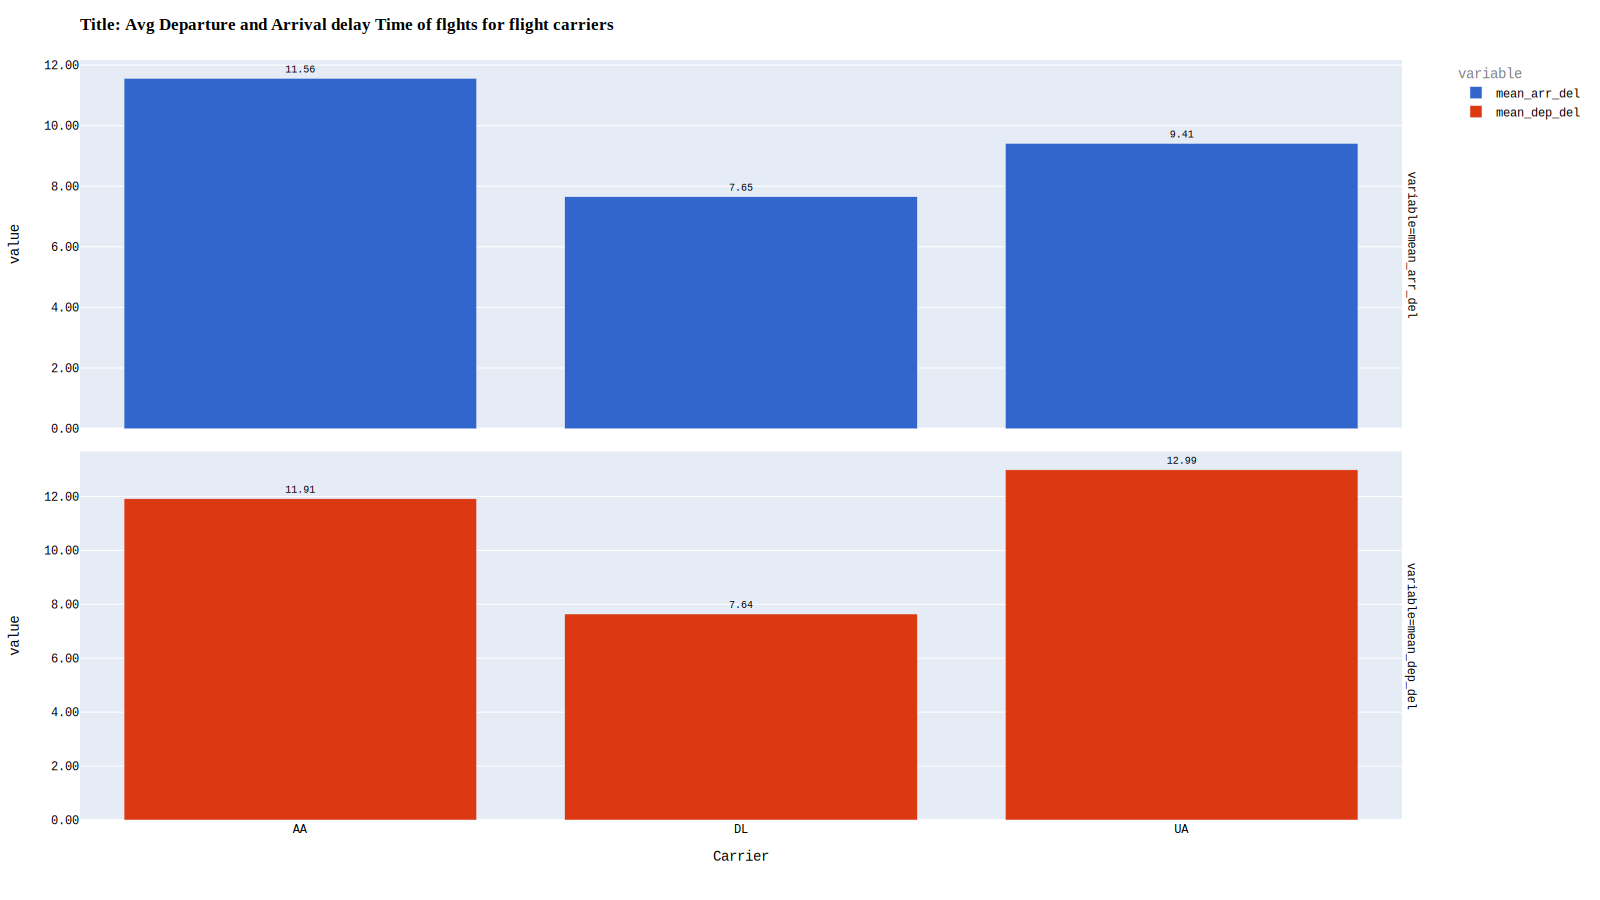

In [123]:
p=(
df_mean  
.query(" cancelled == 0 ")   
.melt(id_vars= ["cancelled", "uniq_carrier"] )
.query('variable in ["mean_dep_del", "mean_arr_del"]')  
.plot.bar(x="uniq_carrier", y = "value",     
                barmode='group', 
                color= "variable", 
                color_discrete_sequence=px.colors.qualitative.G10,
                width= 1600, height=900,
                #color_discrete_map= {"mean_arr_del": 'orange',"mean_dep_del": 'blue'},

                facet_row= "variable", text_auto = True) 
.update_traces(textposition='outside',textfont_size =10) 
.update_yaxes(matches=None,showticklabels=True, tickformat= ".2f")
.update_xaxes(matches=None)    
.update_layout(            
    title = "<b> Title: Avg Departure and Arrival delay Time of flghts for flight carriers </b>",
    xaxis_title = "Carrier",                       
    font_family="Courier New",
    font_color="black",
    font_size = 12,
    title_font_family="Times New Roman",
    title_font_color="black",        
    legend_title_font_color= "grey"
    )                       
)
p.show("svg")

In [124]:
df.isna().sum().to_frame().T

,cancelled,month,dep_time,uniq_carrier,sched_elap_time,arr_delay,dep_delay,dis_ml,time,hour
0,0,0,0,0,0,0,0,29,0,0


In [125]:
df_stat_month=(
     df
     .groupby(["cancelled", "month" ])
     .agg(
        mean_elp_time = pd.NamedAgg("sched_elap_time", "mean"),
        mean_arr_del = pd.NamedAgg("arr_delay", "mean"),
        mean_dep_del = pd.NamedAgg("dep_delay", "mean"),
        mean_dis_ml = pd.NamedAgg("dis_ml", "mean"),
        count_cancel = pd.NamedAgg("cancelled", "count")
    )
    .reset_index()
     .assign(
              cancelled= lambda df_: df_.cancelled.astype("category")     
              )
)
df_cancel_monthly= pd.merge(df_stat_month, df_stat_month.groupby("month").agg(monthly_flights= pd.NamedAgg("count_cancel", "sum")).reset_index(),
                            how= "left",
                            on = "month").assign(              
                                                 perc_flight_cancel= lambda df_: (df_.count_cancel/df_.monthly_flights).round(2)
                                                 )
df_cancel_monthly.head()

,cancelled,month,mean_elp_time,mean_arr_del,mean_dep_del,mean_dis_ml,count_cancel,monthly_flights,perc_flight_cancel
0,0,1,166.211538,8.620192,11.088942,1018.038462,416,539,0.77
1,0,2,170.907193,13.104408,14.566125,1049.046404,431,571,0.75
2,0,3,164.757732,11.239691,11.778351,1007.783505,388,517,0.75
3,0,4,170.904762,10.460317,10.793651,1075.111364,441,588,0.75
4,0,5,163.495556,6.306667,7.975556,1017.405345,450,515,0.87


> Graph below shows a cancelled vs not cancelled flights over the 12 months. 
* Highest percentage of cancelled flights are in months, 1,2,3,4, and 12

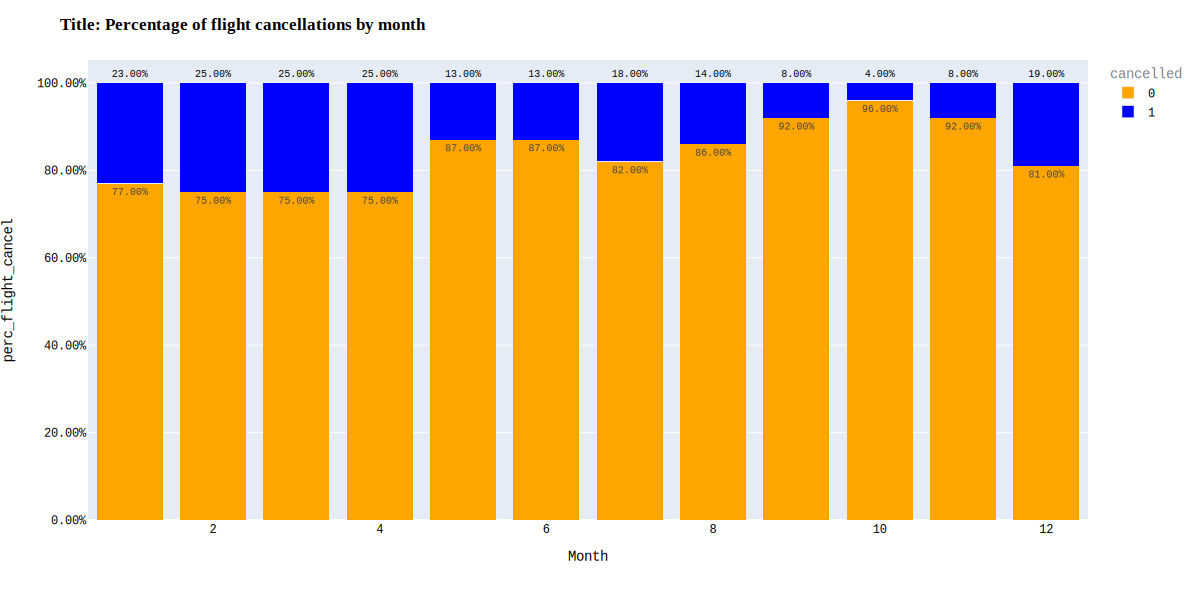

In [126]:
(
    df_cancel_monthly
    .plot.bar(x= "month", y= "perc_flight_cancel", 
            color = "cancelled", 
            color_discrete_map={0: 'orange',1: 'blue'},
            #color_discrete_sequence=['orange', 'blue'],
            width= 1200, height=600,
            barmode= "stack", text_auto= True ) 
    #.update_layout(yaxis_tickformat = '%')
     .update_traces(textposition='outside',textfont_size =10)  
     .update_yaxes(tickformat = ".2%")
     .update_layout(            
            title = "<b> Title: Percentage of flight cancellations by month </b>",
            xaxis_title = "Month",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
).show("svg")

> Graph below shows total number of flights per month. 
* From previous graph we find that highest percetage of cancellations are in months 1,2,3,4, and 12. From graph below we see these are the busiest months. 
* Probably busy months have more issues with managing flights which is causing higher percentage of cancellations

/var/folders/3d/z1qzqy6s4p5_06dtsnr__3qh0000gn/T/ipykernel_5449/2415528424.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



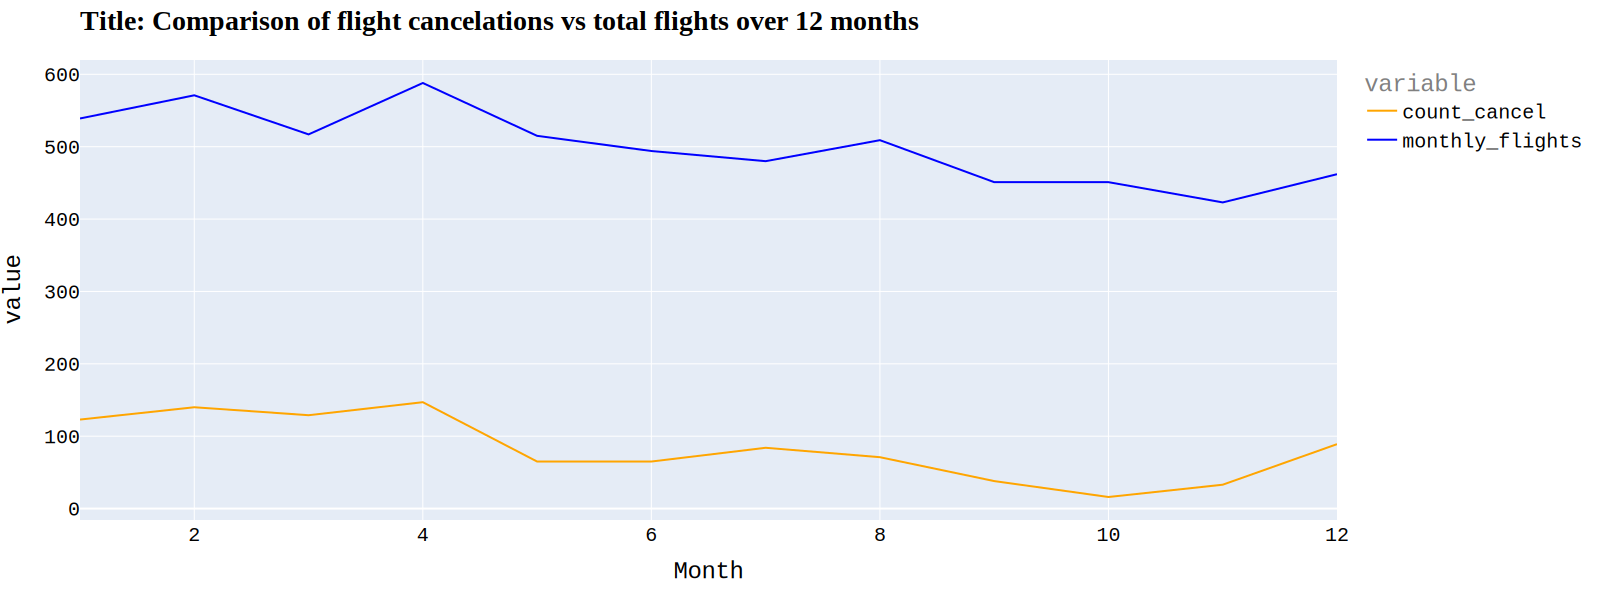

In [127]:
(
    df_cancel_monthly
    .query("cancelled == 1")
    .groupby("month")
    .sum()
    .reset_index()
    .melt(id_vars=["month"] )
    .query('variable in ["monthly_flights", "count_cancel"]')
    .plot.line(x= "month", y= "value", 
                color="variable",                 
                #color_discrete_map={ "count_cancel": 'orange',"monthly_flights": 'blue'},
                color_discrete_sequence= ['orange','blue'],
                width= 1600, height=600,)     
    #.update_traces(textposition='outside')  
     .update_layout(            
            title = "<b> Title: Comparison of flight cancelations vs total flights over 12 months </b>",
            xaxis_title = "Month",                       
            font_family="Courier New",
            font_color="black",
            font_size = 20,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
).show("svg")

In [128]:
df_stat_hourly=(
     df
     .assign(cancelled = df.cancelled.astype("category"),
            hour = pd.to_datetime(df.time).dt.hour,
            )
     .groupby(["cancelled","hour" ])
     .agg(
        mean_elp_time = pd.NamedAgg("sched_elap_time", "mean"),
        mean_arr_del = pd.NamedAgg("arr_delay", "mean"),
        mean_dep_del = pd.NamedAgg("dep_delay", "mean"),
        mean_dis_ml = pd.NamedAgg("dis_ml", "mean"),
        count_cancel = pd.NamedAgg("cancelled", "count")
    )
    .reset_index()
     .assign(
              cancelled= lambda df_: df_.cancelled.astype("category")     
              )
)
df_stat_hourly.head()


,cancelled,hour,mean_elp_time,mean_arr_del,mean_dep_del,mean_dis_ml,count_cancel
0,0,0,207.916667,-4.000000,4.083333,1556.333333,12
1,0,1,190.000000,69.000000,70.000000,1464.000000,1
2,0,5,139.611111,0.222222,-3.166667,791.333333,18
3,0,6,162.587349,1.099398,1.114458,1016.933735,332
4,0,7,170.896936,2.392758,2.153203,1045.969101,359


In [129]:
df_cancel_hourly=  pd.merge(df_stat_hourly, df_stat_hourly.groupby(["hour"]).agg(hourly_flights= pd.NamedAgg("count_cancel", "sum")).reset_index(),
                             how= "left" ,
                             on = ["hour"]).assign(              
                                                 perc_flight_cancel= lambda df_: (df_.count_cancel/df_.hourly_flights).round(2)
                                                 )
df_cancel_hourly.head()

,cancelled,hour,mean_elp_time,mean_arr_del,mean_dep_del,mean_dis_ml,count_cancel,hourly_flights,perc_flight_cancel
0,0,0,207.916667,-4.000000,4.083333,1556.333333,12,12,1.00
1,0,1,190.000000,69.000000,70.000000,1464.000000,1,1,1.00
2,0,5,139.611111,0.222222,-3.166667,791.333333,18,20,0.90
3,0,6,162.587349,1.099398,1.114458,1016.933735,332,400,0.83
4,0,7,170.896936,2.392758,2.153203,1045.969101,359,416,0.86


> Graphs below shows a cancelled vs not cancelled flights and the total number of flights for 24 hours.
* Highest percentage of cancelled flights are during the busy hours.

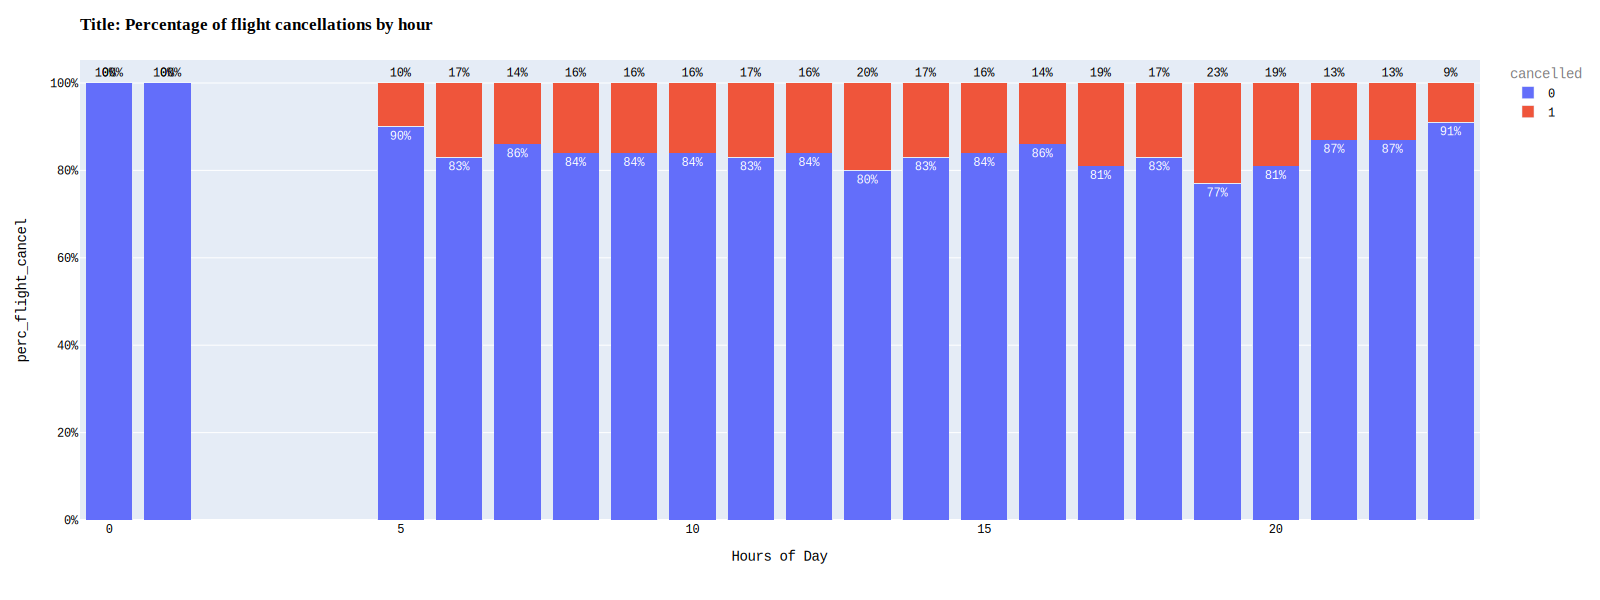

In [130]:
(
    df_cancel_hourly
    .plot.bar(x= "hour", y= "perc_flight_cancel", 
              color = "cancelled", barmode= "stack", 
              text_auto= True,               
              width= 1600, height=600,
              )     
     .update_traces(textposition='outside')  
     .update_yaxes(tickformat = ".0%")     
     .update_layout(            
            title = "<b> Title: Percentage of flight cancellations by hour </b>",
            xaxis_title = "Hours of Day",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
).show("svg")

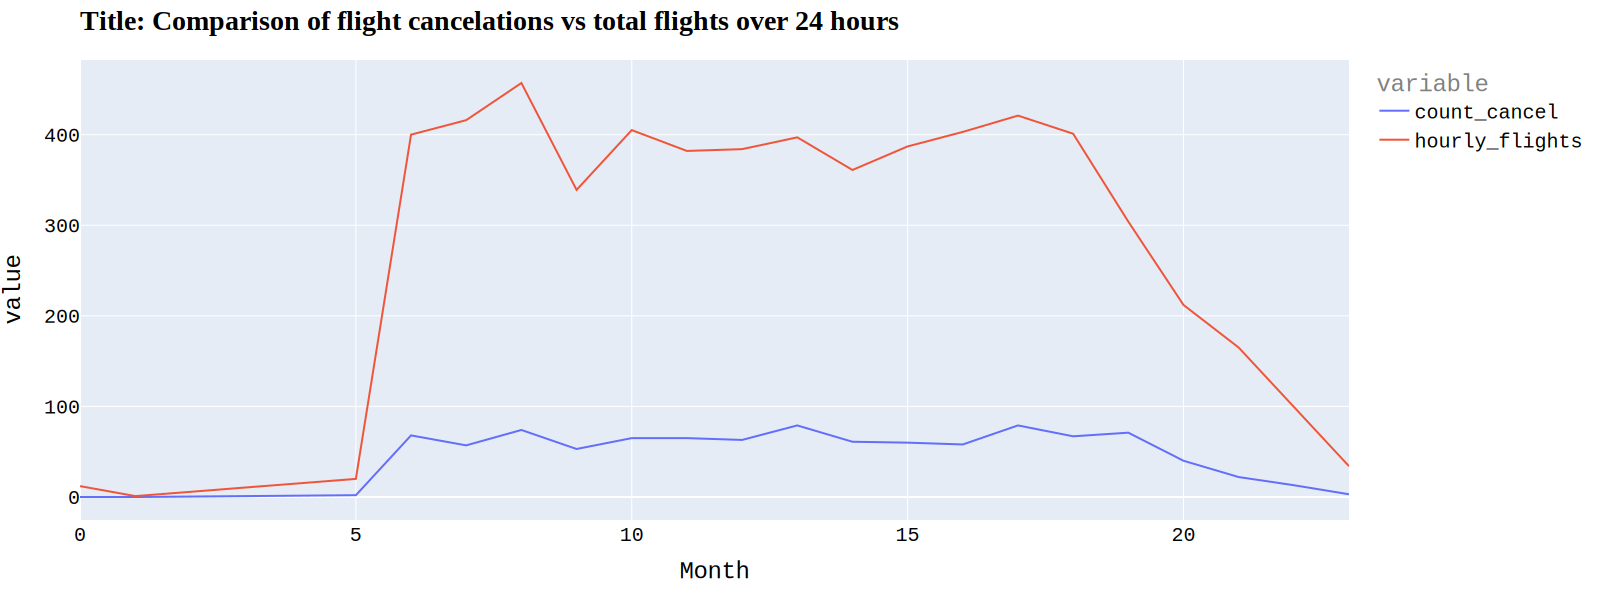

In [151]:
p=(
    df_cancel_hourly
    .query("cancelled == 1")
    .groupby("hour")
    .agg("sum", numeric_only=True)
    .reset_index()
    .melt(id_vars=["hour"] )
    .query('variable in ["hourly_flights", "count_cancel"]')
    .plot.line(x= "hour", y= "value", color="variable", width= 1600, height=600,)     
    #.update_traces(textposition='outside')  
     .update_layout(            
            title = "<b> Title: Comparison of flight cancelations vs total flights over 24 hours </b>",
            xaxis_title = "Month",                       
            font_family="Courier New",
            font_color="black",
            font_size = 20,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
)
p.show("svg")

> taking average by cancelled or not cancelled flight shows us some useful information
* average distance and duration travel is lower for cancelled flights
* avg arrival delay is 0 as cancelled flights wont have arrival delay as they arent flying
* average departure time shows also near to 0 average this also seems like a data error as cancelled flights wont depart and shouldnt have any departure delay values.

In [132]:
df.groupby("cancelled").mean()

/var/folders/3d/z1qzqy6s4p5_06dtsnr__3qh0000gn/T/ipykernel_5449/3607961424.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,month,sched_elap_time,arr_delay,dep_delay,dis_ml,hour
cancelled,,,,,,
0,6.4278,164.1178,9.7356,10.9594,1011.432552,13.0066
1,5.1820,149.5720,0.0000,0.0960,858.587576,13.2310


In [133]:
df.query("cancelled == 1 & dep_delay != 0")

,cancelled,month,dep_time,uniq_carrier,sched_elap_time,arr_delay,dep_delay,dis_ml,time,hour
48,1,12,1844,UA,187,0,46,1197.0,18:44,18
155,1,11,630,DL,73,0,-2,185.0,06:30,6
193,1,11,826,UA,227,0,-6,1739.0,08:26,8
307,1,12,2240,DL,57,0,13,215.0,22:40,22
334,1,11,1310,DL,352,0,-2,2615.0,13:10,13
409,1,10,759,UA,281,0,14,1619.0,07:59,7
540,1,12,1445,AA,60,0,3,190.0,14:45,14
550,1,12,1055,DL,158,0,41,950.0,10:55,10
849,1,11,900,UA,89,0,-7,334.0,09:00,9
862,1,10,1300,AA,90,0,-4,334.0,13:00,13


> Lets explore if there is any relationship between distance travelled and schedule duratin
* as expected the duration and distance travelled have a psotive and direcet relationship which makes sense

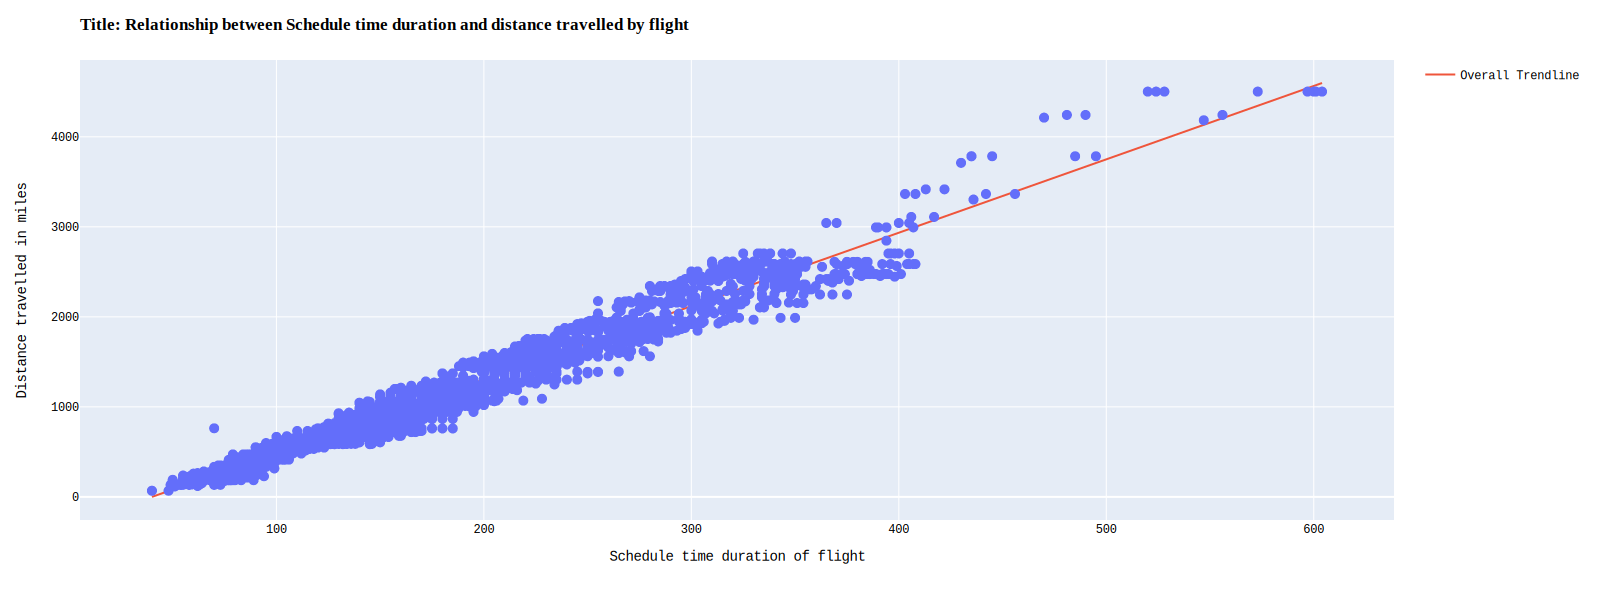

In [149]:
#!pip install statsmodels
p=(
    df
     .query("cancelled == 0")     
     .assign(cancelled = df.cancelled.astype("category"))                  
     .plot.scatter(x= "sched_elap_time", y= "dis_ml",
                  trendline= "ols", 
                  #log_y= True,                   
                  width= 1600, height=600,
                  trendline_scope="overall"                                 
                  )           
    .update_traces(marker={"size":10})
    .update_layout(            
            title = "<b> Title: Relationship between Schedule time duration and distance travelled by flight </b>",
            xaxis_title = "Schedule time duration of flight",                       
            yaxis_title = "Distance travelled in miles",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )      
)
p.show("svg")

> Graph shows relationship between arrival departure delay
* Flights which arrive late also deprt late.

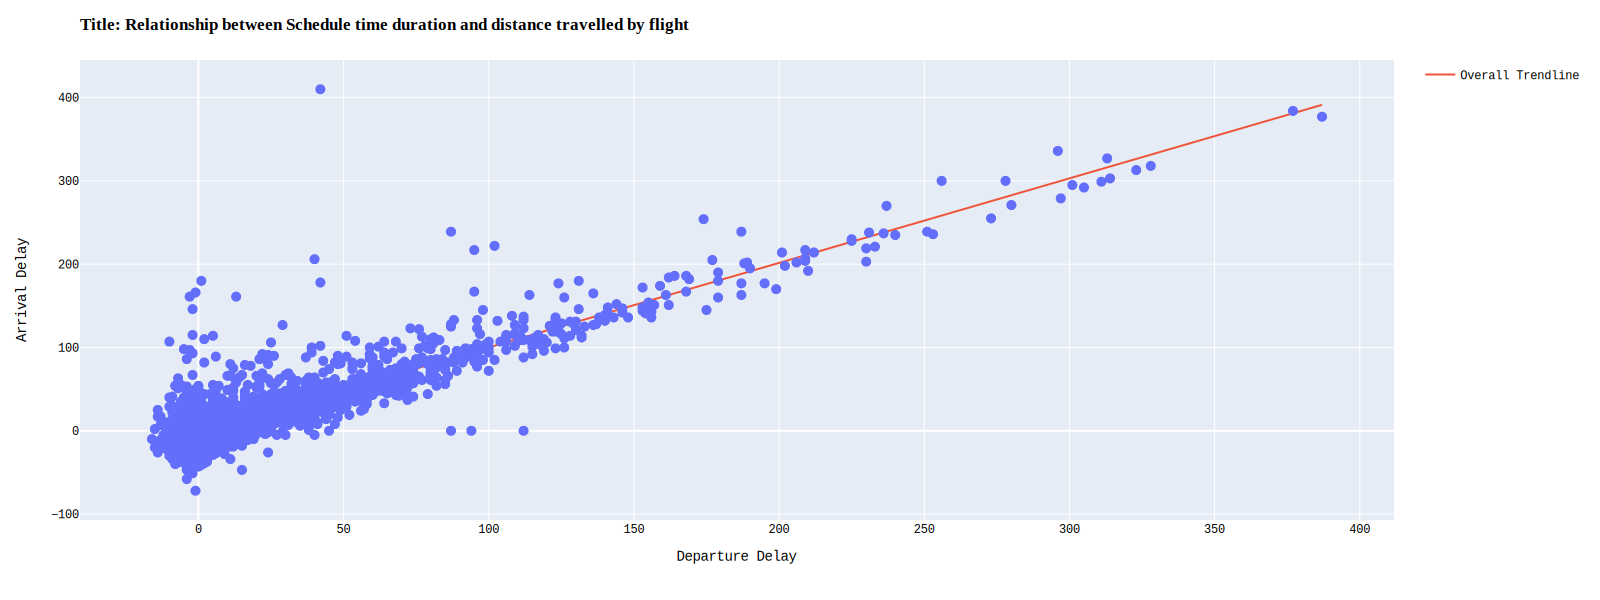

In [148]:
p=(
    df
     .query("cancelled == 0")     
     .assign(cancelled = df.cancelled.astype("category"))                  
     .plot.scatter(x= "dep_delay", y= "arr_delay",
                  trendline= "ols", 
                  #log_y= True,                   
                  width= 1600, height=600,
                  trendline_scope= "overall"                                 
                  )           
    .update_traces(marker={"size":10})
    .update_layout(            
            title = "<b> Title: Relationship between Schedule time duration and distance travelled by flight </b>",
            xaxis_title = "Departure Delay",                       
            yaxis_title = "Arrival Delay",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                       
    
)
p.show("svg")

> Graph below shows relationship between distance travelled and arrival and departure delay

* We find that Arrival and departure delay have a positive but weak relationship with distance travelled of the flights
* We have missing arrival and departure delay for all cancelled flights.
* One way of filling those values can be to use use regression and make predictions for arrival and departure delay time.

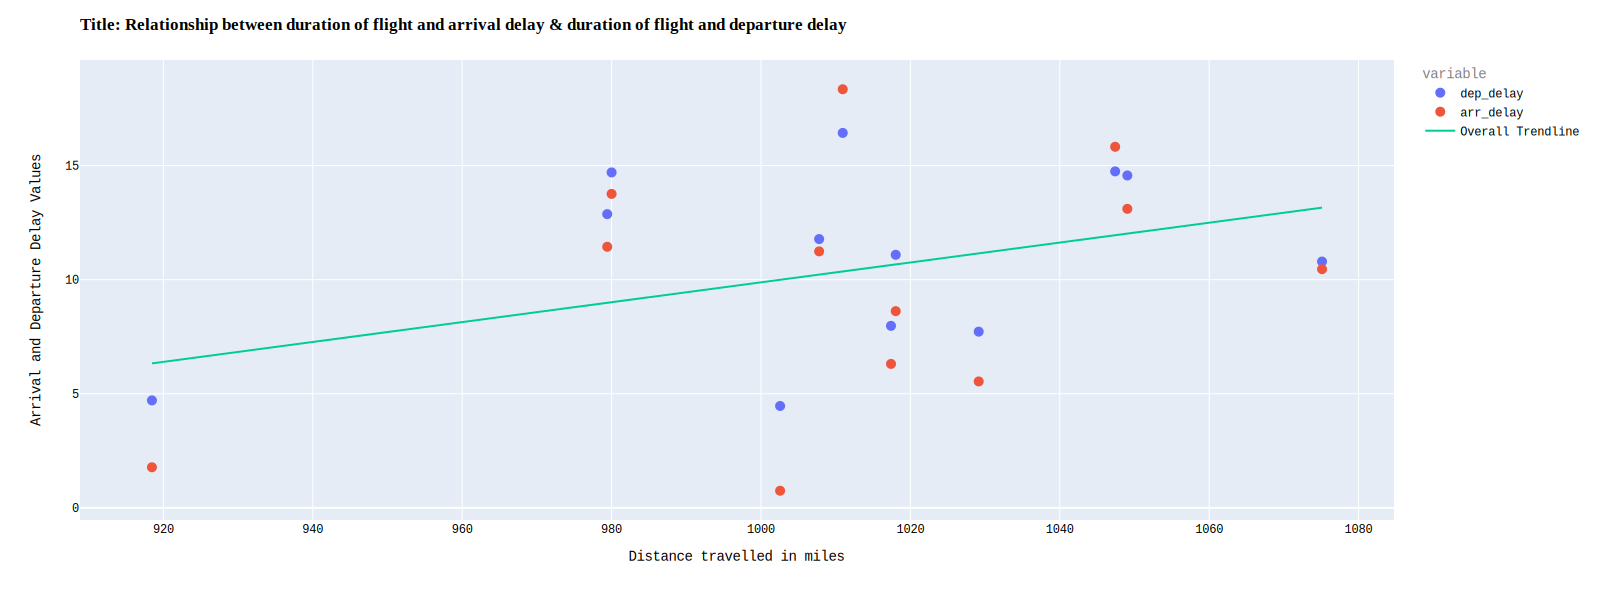

In [147]:
p=(
    df
     .query("cancelled == 0")     
     .assign(cancelled = df.cancelled.astype("category"))            
     .groupby(["month"])
     .agg("mean", numeric_only= True)    
     .reset_index()
     .melt(id_vars = ["dis_ml"], value_vars= ["dep_delay", "arr_delay"])
    .plot.scatter(x= "dis_ml", y= "value",
                  trendline= "ols", 
                  #log_y= True, 
                  color= "variable" ,                                  
                  width= 1600, height=600,
                  trendline_scope="overall"                                 
                  )           
    .update_traces(marker={"size":10})
    .update_layout(            
            title = "<b> Title: Relationship between duration of flight and arrival delay & duration of flight and departure delay </b>",
            xaxis_title = "Distance travelled in miles",                       
            yaxis_title = "Arrival and Departure Delay Values",                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )                         
)
p.show("svg")

### 2.1 Building Model 
* Predictive a model to predict whether a flight will be canceled based on available Data.
* Which airline has the least risk of cancellation. 

In [137]:
GRAY1 = "#231F20";GRAY2 = "#414040";GRAY3 = "#555655";GRAY4 = "#646369";GRAY5 = "#76787B";GRAY6 = "#828282";GRAY7 = "#929497";GRAY8 = "#A6A6A5";GRAY9 = "#BFBEBE";BLUE1 = "#174A7E";
BLUE2 = "#4A81BF";BLUE3 = "#94B2D7";BLUE4 = "#94AFC5";BLUE5 = "#22435e";BLUE6 = "#95B3D7";RED1 = "#C3514E";RED2 = "#E6BAB7";RED3 = "#800000";GREEN1 = "#0C8040";GREEN2 = "#9ABB59"
GREEN3 = "#31859C";GREEN4 = "#4BACC6";GREEN5 = "#93CDDD";ORANGE1 = "#F79747";ORANGE2 = "#FAC090"; BLUE_CPD1= "#137FA7";BLUE_CPD2= "#00385D";BLUE_CPD3= "#EAF6FE";BLUE_CPD4= "#51BCE1"

In [138]:
#!pip install seaborn
import seaborn as sns
df_corr =df.corr()
df_corr

/var/folders/3d/z1qzqy6s4p5_06dtsnr__3qh0000gn/T/ipykernel_5449/1437871735.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,cancelled,month,sched_elap_time,arr_delay,dep_delay,dis_ml,hour
cancelled,1.000000,-0.135121,-0.069447,-0.101461,-0.127849,-0.087669,0.018247
month,-0.135121,1.000000,-0.020219,-0.024267,-0.015366,-0.018286,-0.008098
sched_elap_time,-0.069447,-0.020219,1.000000,0.008899,0.032081,0.982349,-0.017585
arr_delay,-0.101461,-0.024267,0.008899,1.000000,0.896270,0.007636,0.106690
dep_delay,-0.127849,-0.015366,0.032081,0.896270,1.000000,0.029980,0.134506
dis_ml,-0.087669,-0.018286,0.982349,0.007636,0.029980,1.000000,-0.018024
hour,0.018247,-0.008098,-0.017585,0.106690,0.134506,-0.018024,1.000000


> Graph below shows Corelation results for the variables
* we find that all variables have correlation with our target variable (cancelled or not cancelled)
* Distance travelled and departure delay has the highest correlatin with target variable
* Distance to destination and flight duration have high correlation.
* Arrival and Departure delay also have high correlatin.
* For predictive model building i will dop variable with above .9 correlation
* I will drop schedule_elap_time variable and keep dis_ml variable for model building
* I will drop Arrival delay variable and keep departure delay variable for model building

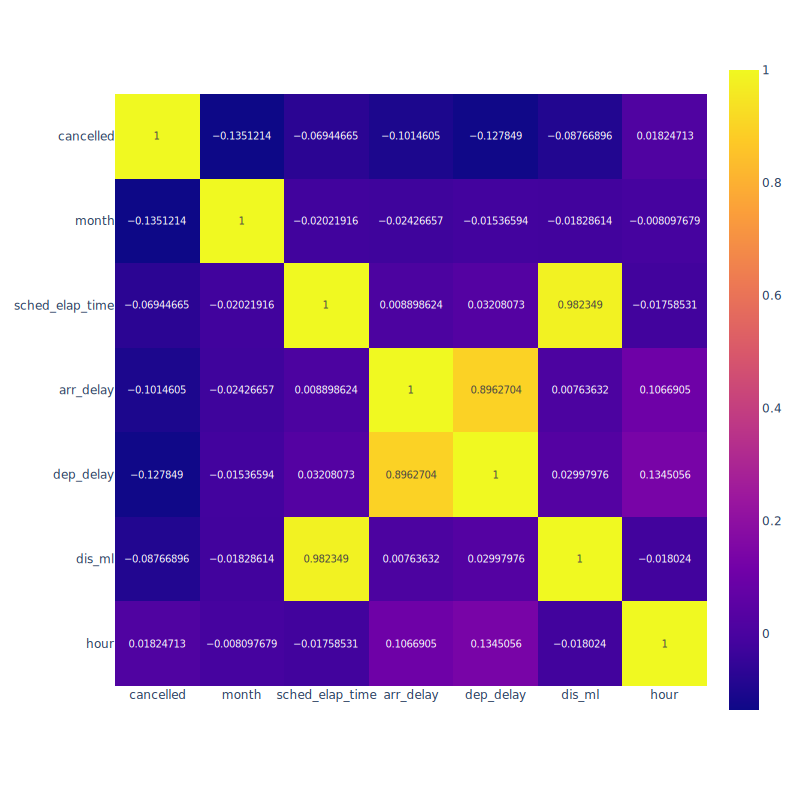

In [145]:
fig=px.imshow(df_corr,
    x=df_corr.columns, y= df_corr.index, width= 800, height=800, text_auto=True)
fig.show("svg")

In [140]:
df_final= df.drop(columns= ["time","dep_time", "sched_elap_time","arr_delay"]).copy()
#  Define categorical and non categorical variables
# * We will convert following variables to categorical
# * cancelled(target variable), month, uniq_carrier, and hour.
target_col= ["cancelled"]
cat_cols= ["uniq_carrier", "month", "hour"]
non_cat_cols = df_final.columns[~ df_final.columns.isin(target_col+cat_cols)].tolist()

### Pair plot

In [141]:
import seaborn as sns
#sns.pairplot(df_final, hue='cancelled', height=3)

### Box Plots

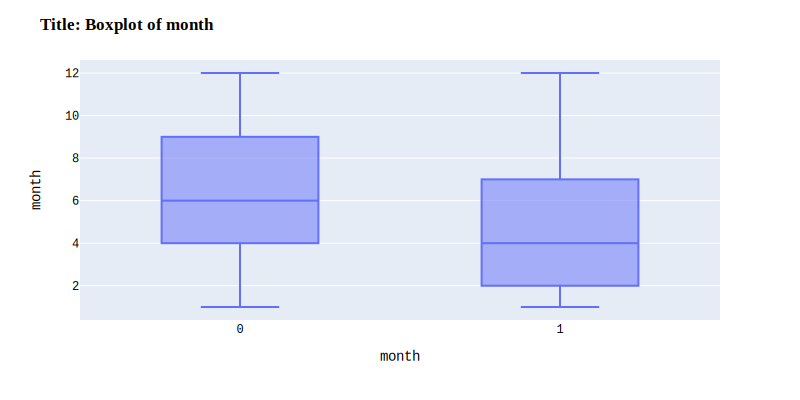

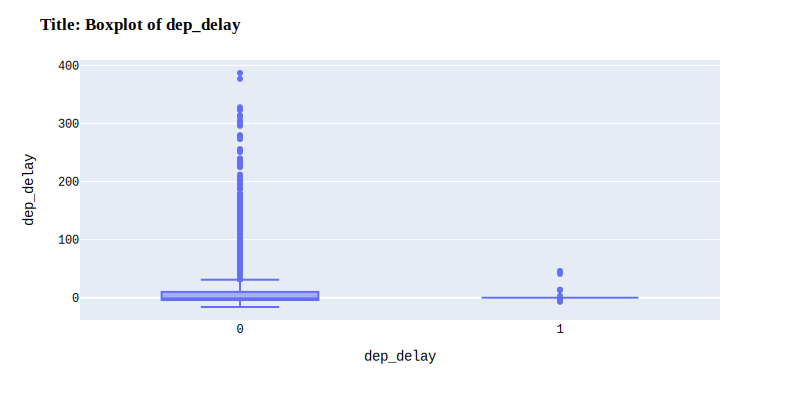

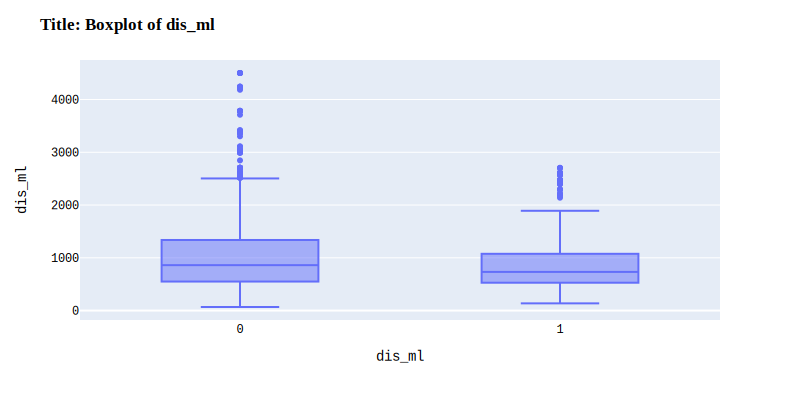

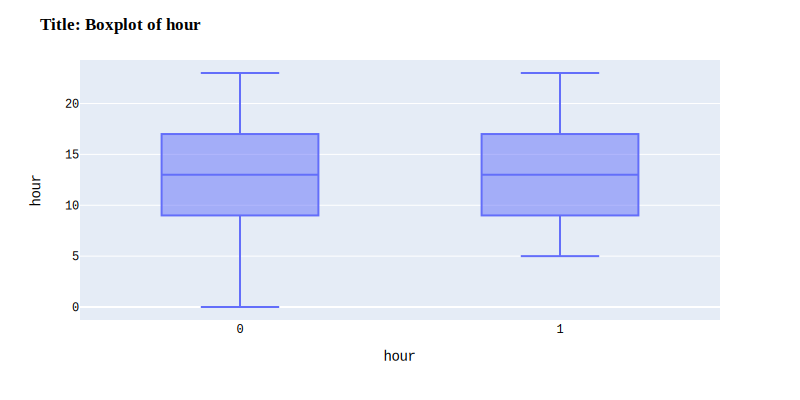

[None, None, None, None]

In [142]:
def plot_box(var):
    p=(
        df_final
        .plot.box(x="cancelled",y=var, width= 800, height=400)       
        .update_layout(
            #bargap=0.1,
            title = "<b> Title: Boxplot of {} </b>".format(var),
            xaxis_title = var,                       
            font_family="Courier New",
            font_color="black",
            font_size = 12,
            title_font_family="Times New Roman",
            title_font_color="black",        
            legend_title_font_color= "grey"
            )        
    )
    return p.show("svg")

list(
    map(
        plot_box, df_final.columns[~ df_final.columns.isin(["uniq_carrier","cancelled"])]
        )
    )
